<a href="https://colab.research.google.com/github/MGomezN/cicese_ert_escuela_verano_2022/blob/main/stg_filter_analysis_initial_settings_EarthImager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import numpy as np


# Función para leer datos stg y aplicarles diferentes filtros

In [2]:
def stg_initial_settings_filters(name,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes):
  ''' Función para leer datos stg y verificar qué datos se pierden al aplicar diferentes filtros en los "sttings iniciales" de Earth Imager'''
  # Para extraer el nombre del transecto y agregarlo automáticamente a los títulos de los plots
  survey_name=name.split('/')[-1]
  
  # Estos nombres van de acuerdo a lo que especifique el fabricante
  columns = [
          'data_number', #data record number
          'USER', 
          'date',
          'time',
          'V/I',
          'error_rep',
          'I_mA', #Output current in mA
          'apres',
          'command file identifier', 
          'XA',
          'Y-coordinate for the A-electrode',
          'Z-coordinate for the A-electrode',
          'XB',
          'Y-coordinate for the B-electrode',
          'Z-coordinate for the B-electrode',
          'XM',
          'Y-coordinate for the M-electrode',
          'Z-coordinate for the M-electrode',
          'XN',
          'Y-coordinate for the N-electrode',
          'Z-coordinate for the N-electrode'
      ]

  stg_crudo = pd.read_csv(name, skiprows=3, header=None, names=columns)

  stg_crudo.head()

  print('El valor máximo en x de los electrodos es', stg_crudo.XN.max())
  stg_crudo.describe()


  stg_columnas_relevantes=stg_crudo.drop(['USER','command file identifier',
                                        
          'Y-coordinate for the A-electrode',
          'Z-coordinate for the A-electrode',  
          'Y-coordinate for the B-electrode',
          'Z-coordinate for the B-electrode',
          'Y-coordinate for the M-electrode',
          'Z-coordinate for the M-electrode',
          'Y-coordinate for the N-electrode',
          'Z-coordinate for the N-electrode'],axis=1)
  stg_columnas_relevantes['V_mV']= (stg_columnas_relevantes['V/I'] * ((stg_columnas_relevantes.I_mA)) )
  stg_columnas_relevantes['xp']=(stg_columnas_relevantes.XA + stg_columnas_relevantes.XB + stg_columnas_relevantes.XM + stg_columnas_relevantes.XN)/4
  stg_columnas_relevantes['n']= (stg_columnas_relevantes.XM - stg_columnas_relevantes.XA )/ (stg_columnas_relevantes.XA - stg_columnas_relevantes. XB)
  stg_columnas_relevantes['a']= np.abs((stg_columnas_relevantes.XA - stg_columnas_relevantes.XB ))
  stg_columnas_relevantes['z_pseudo']= (stg_columnas_relevantes.a)/2 + (stg_columnas_relevantes.n * stg_columnas_relevantes.a )/2


  stg_columnas_relevantes.head()

  # Filtros
  stg_columnas_relevantes_filtros = copy.deepcopy(stg_columnas_relevantes)
  # Pseudosección con todos los datos completos
  fig=px.scatter(stg_columnas_relevantes, y=stg_columnas_relevantes.z_pseudo,
                x=stg_columnas_relevantes.xp, color=stg_columnas_relevantes['V/I'],
                labels={'Distancia':'X [m]'},
                title="Pseudoseccion de datos crudos: %s"%survey_name,
                color_continuous_scale=px.colors.sequential.Rainbow) 
  fig.update_yaxes(autorange="reversed")
  fig.update_traces(marker={'size': 20})
  fig.show() 

  print('OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg', '\n',
  'Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero')

  # NegAppRes
    #filtro
  stg_columnas_relevantes_filtroNegAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] >= 0)] # los datos que quedan después de aplicar el filtro
    #conteo de cuántos datos se van
  sum_lost_NegAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroNegAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque las apres son negativas son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] < 0)].index + 1,  'en total:', sum_lost_NegAppRes)
  print('\n')


  # V/I
    #filtro
  stg_columnas_relevantes_filtroVI = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] >= MinVoverI)] 
    #conteo de cuántos datos se van
  sum_lost_VI=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroVI)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque son menores al mínimo V/I son:',stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] < MinVoverI)].index + 1,
        'en total:', sum_lost_VI)


  # Min voltage
    #filtro
  stg_columnas_relevantes_filtroVmin = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V_mV'] >= MinVoltage)] 
    #conteo de cuántos datos se van
  sum_lost_Vmin=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroVmin)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por debajo del voltaje mínimo son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V_mV'] < MinVoltage)].index + 1,  'en total:', sum_lost_Vmin)


  # MaxRepeatErr
    #filtro
  stg_columnas_relevantes_filtroMaxRepeatErr = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['error_rep'] <= MaxRepeatErr)] 
    #conteo de cuántos datos se van
  sum_lost_MaxRepeatErr = len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMaxRepeatErr)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por arriba del MaxRepeatErr son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['error_rep'] > MaxRepeatErr)].index + 1,  'en total:', sum_lost_MaxRepeatErr)


  # MaxAppRes
    #filtro
  stg_columnas_relevantes_filtroMaxAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] <= MaxAppRes)] 
    #conteo de cuántos datos se van
  sum_lost_MaxAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMaxAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por arriba del MaxAppRes son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] > MaxAppRes)].index + 1,  'en total:', sum_lost_MaxAppRes)



  # MinAppRes
    #filtro
  stg_columnas_relevantes_filtroMinAppRes = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] >= MinAppRes)] 
    #conteo de cuántos datos se van
  sum_lost_MinAppRes=len(stg_columnas_relevantes) - len(stg_columnas_relevantes_filtroMinAppRes)
    # Aviso
  print('\n')
  print('Los datos a eliminar porque están por debajo del MinAppRes son:',
        stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['apres'] < MinAppRes)].index + 1,  'en total:', sum_lost_MinAppRes)
  print('\n')

  fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
  # plot time signal:
  axs[0, 0].set_title("Apres Negativas")
  axs[0, 0].plot(stg_columnas_relevantes_filtroNegAppRes.xp,stg_columnas_relevantes_filtroNegAppRes.z_pseudo,'*',color='C0')
  axs[0, 0].set_xlabel("Distance [m]")
  axs[0, 0].set_ylabel("Z [m]")
  axs[0, 0].invert_yaxis()


  axs[0, 1].set_title("V/I")
  axs[0, 1].plot(stg_columnas_relevantes_filtroVI.xp,stg_columnas_relevantes_filtroVI.z_pseudo,'*',color='C0')
  axs[0, 1].set_xlabel("Distance [m]")
  axs[0, 1].set_ylabel("Z [m]")
  axs[0, 1].invert_yaxis()

  # plot different spectrum types:
  axs[1, 0].set_title("Voltaje Min")
  axs[1, 0].plot(stg_columnas_relevantes_filtroVmin.xp,stg_columnas_relevantes_filtroVmin.z_pseudo,'*', color='C0')
  axs[1, 0].set_xlabel("Distance [m]")
  axs[1, 0].set_ylabel("Z [m]")
  axs[1, 0].invert_yaxis()

  axs[1, 1].set_title("Repeat error")
  axs[1, 1].plot(stg_columnas_relevantes_filtroMaxRepeatErr.xp,stg_columnas_relevantes_filtroMaxRepeatErr.z_pseudo,'*', color='C0')
  axs[1, 1].set_xlabel("Distance [m]")
  axs[1, 1].set_ylabel("Z [m]")
  axs[1, 1].invert_yaxis()

  axs[2, 0].set_title("Min appRes")
  axs[2, 0].plot(stg_columnas_relevantes_filtroMinAppRes.xp,stg_columnas_relevantes_filtroMinAppRes.z_pseudo,'*', color='C0')
  axs[2, 0].set_xlabel("Distance [m]")
  axs[2, 0].set_ylabel("Z [m]")
  axs[2, 0].invert_yaxis()

  axs[2, 1].set_title("Max appres")
  axs[2, 1].plot(stg_columnas_relevantes_filtroMaxAppRes.xp,stg_columnas_relevantes_filtroMaxAppRes.z_pseudo,'*', color='C0')
  axs[2, 1].set_xlabel("Distance [m]")
  axs[2, 1].set_ylabel("Z [m]")
  axs[2, 1].invert_yaxis()
  fig.suptitle("Transecto: %s"%survey_name, fontsize=16, y=1.1)


  fig.tight_layout()

  plt.show()

  # Aplicando todos los filtros a la vez:
  # V/I
    #filtro
  stg_columnas_relevantes_filtroVI = stg_columnas_relevantes_filtros[(stg_columnas_relevantes_filtros['V/I'] >= MinVoverI)] 

  # Min voltage
    #filtro
  stg_columnas_relevantes_filtroVmin = stg_columnas_relevantes_filtroVI [(stg_columnas_relevantes_filtroVI ['V_mV'] >= MinVoltage)] 

  # MaxRepeatErr
    #filtro
  stg_columnas_relevantes_filtroMaxRepeatErr = stg_columnas_relevantes_filtroVmin[(stg_columnas_relevantes_filtroVmin['error_rep'] <= MaxRepeatErr)] 

  # MaxAppRes
    #filtro
  stg_columnas_relevantes_filtroMaxAppRes = stg_columnas_relevantes_filtroMaxRepeatErr [(stg_columnas_relevantes_filtroMaxRepeatErr ['apres'] <= MaxAppRes)] 

  # MinAppRes
    #filtro
  stg_columnas_relevantes_filtroMinAppRes = stg_columnas_relevantes_filtroMaxAppRes [(stg_columnas_relevantes_filtroMaxAppRes ['apres'] >= MinAppRes)] 

  stg_columnas_relevantes_filtrostodos = copy.deepcopy(stg_columnas_relevantes_filtroMinAppRes)

  # Filtrando resistividad aparente

  plt.plot(stg_columnas_relevantes_filtrostodos.data_number,stg_columnas_relevantes_filtrostodos.apres,'*')
  plt.title("Así se distribuye la resistividad aparente después de aplicar los filtros iniciales: %s"%survey_name)
  plt.xlabel('Número de dato')
  plt.ylabel('Ohm-m')
  plt.show()

  plt.hist(stg_columnas_relevantes_filtrostodos.apres)
  plt.title("Así se distribuye la resistividad aparente después de aplicar los filtros iniciales: %s"%survey_name)
  plt.xlabel('Resistividad Aparente Ohm-m')
  plt.ylabel('Cantidad de datos')
  plt.show()

  # Pseudosección con todos los datos después de todos los filtros
  fig=px.scatter(stg_columnas_relevantes_filtrostodos, y=stg_columnas_relevantes_filtrostodos.z_pseudo,
                x=stg_columnas_relevantes_filtrostodos.xp,
                color=stg_columnas_relevantes_filtrostodos.apres,
                labels={'Distancia':'X [m]'},
  title="Pseudoseccion final después de filtrar: %s"%survey_name,
  color_continuous_scale=px.colors.sequential.Rainbow)
  fig.update_yaxes(autorange="reversed")
  fig.update_traces(marker={'size': 20})
  fig.show()

  print("En resumen, el archivo crudo %s"%survey_name, 'tenía', len(stg_crudo),'y termina con', len(stg_columnas_relevantes_filtrostodos),'\n','Es decir, se pierden',len(stg_crudo)- len(stg_columnas_relevantes_filtrostodos),'datos.' )
  return 

## Criterios para remover datos

In [3]:
MinVoverI=0.0005  #Ohm 5x10-4
MinVoltage=0.2
MaxRepeatErr=120
MaxAppRes=450
MinAppRes=1

# Líneas obtenidas en la escuela de verano CICESE

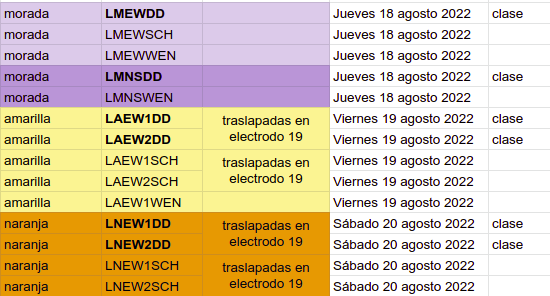

# 🟪  Dipolo - Dipolo  Lineas moradas

El valor máximo en x de los electrodos es 270.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([ 32,  33,  34,  36,  47,  48,  49,  50, 180, 188, 191, 199, 205,
            208, 209, 225, 229, 233, 234],
           dtype='int64') en total: 19




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([ 21,  32,  33,  34,  36,  47,  48,  49,  50,  64, 180, 188, 191,
            199, 205, 208, 209, 225, 229, 233, 234],
           dtype='int64') en total: 21


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([ 21,  29,  32,  33,  34,  35,  36,  43,  44,  46,  47,  48,  49,
             50,  58,  60,  61,  63,  64,  77,  78,  90, 117, 180, 188, 191,
            199, 205, 208, 209, 225, 229, 233, 234],
           dtype='int64') en total: 34


Los datos a eliminar porque están por ar

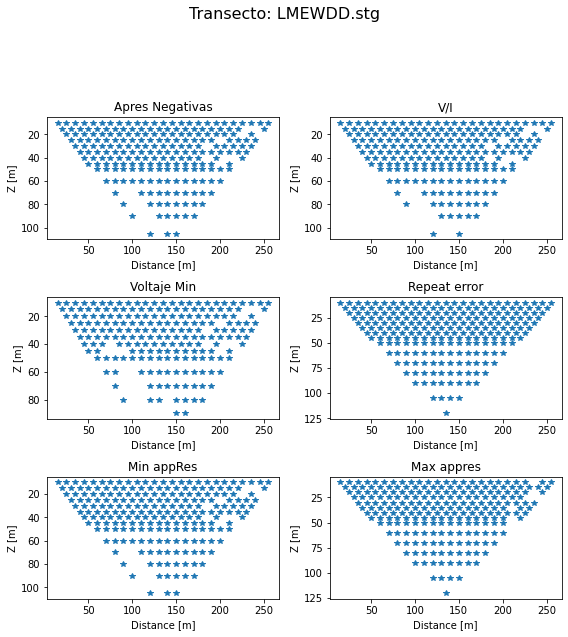

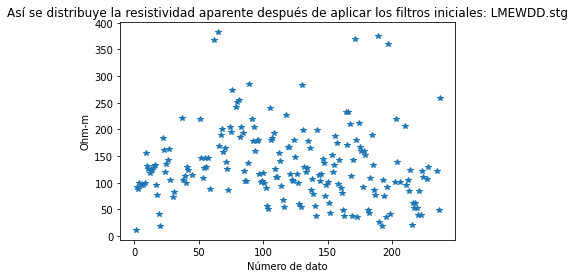

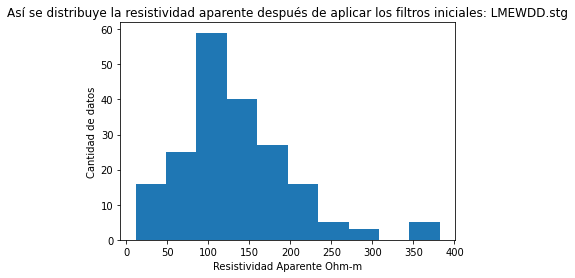

En resumen, el archivo crudo LMEWDD.stg tenía 237 y termina con 196 
 Es decir, se pierden 41 datos.


In [4]:
LMEWDD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWDD.stg'
stg_initial_settings_filters(LMEWDD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([121, 124, 125, 154, 161], dtype='int64') en total: 5




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([121, 124, 125, 154, 161], dtype='int64') en total: 5


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([121, 124, 125, 154, 161], dtype='int64') en total: 5


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([116], dtype='int64') en total: 1


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([121, 124, 125, 154, 161], dtype='int64') en total: 5




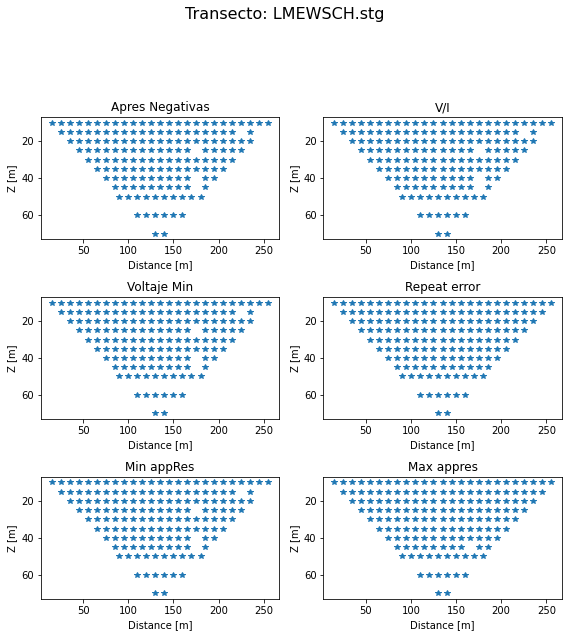

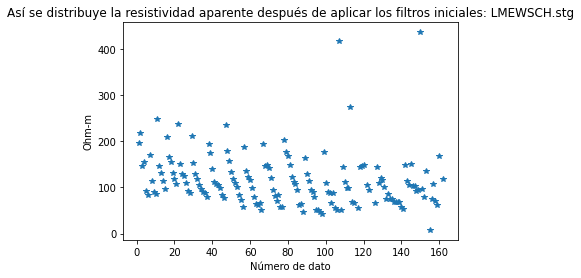

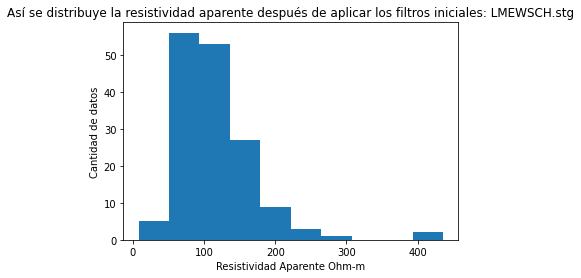

En resumen, el archivo crudo LMEWSCH.stg tenía 162 y termina con 156 
 Es decir, se pierden 6 datos.


In [5]:
LMEWSCH = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWSCH.stg'
stg_initial_settings_filters(LMEWSCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([], dtype='int64') en total: 0




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([], dtype='int64') en total: 0




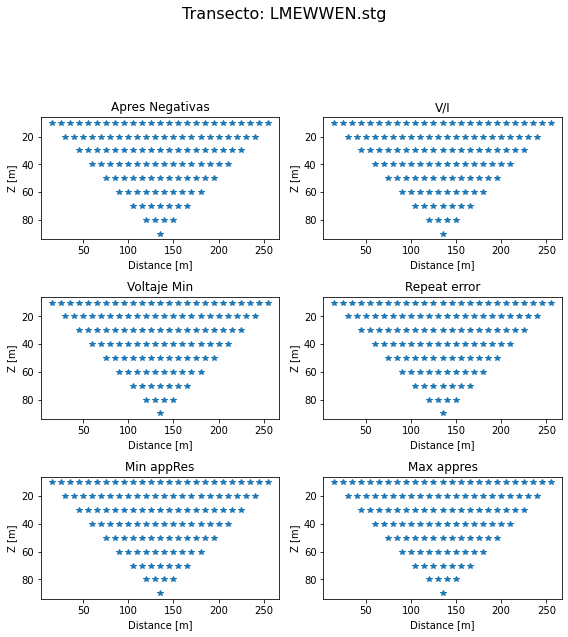

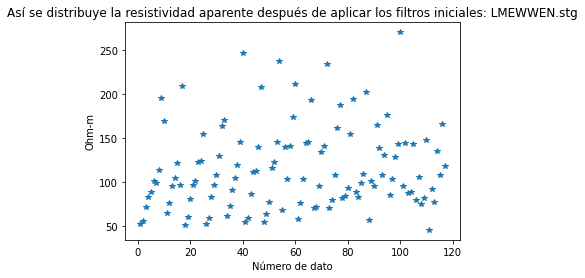

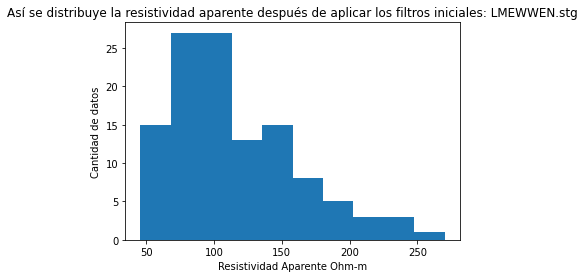

En resumen, el archivo crudo LMEWWEN.stg tenía 117 y termina con 117 
 Es decir, se pierden 0 datos.


In [6]:
LMEWWEN = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LM/LMEWWEN.stg'
stg_initial_settings_filters(LMEWWEN ,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

# 🟨 Dipolo - Dipolo  Lineas amarillas

El valor máximo en x de los electrodos es 270.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([1, 100, 125, 129, 173, 199, 208, 216, 222, 227, 231, 233, 236], dtype='int64') en total: 13




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([1, 36, 100, 125, 129, 173, 199, 208, 216, 222, 227, 231, 233, 236], dtype='int64') en total: 14


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([  1,  20,  21,  29,  32,  33,  34,  35,  36,  43,  44,  47,  48,
             49,  50,  61,  62,  63,  76,  77,  78, 100, 125, 129, 173, 199,
            208, 216, 222, 227, 231, 233, 236],
           dtype='int64') en total: 33


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del M

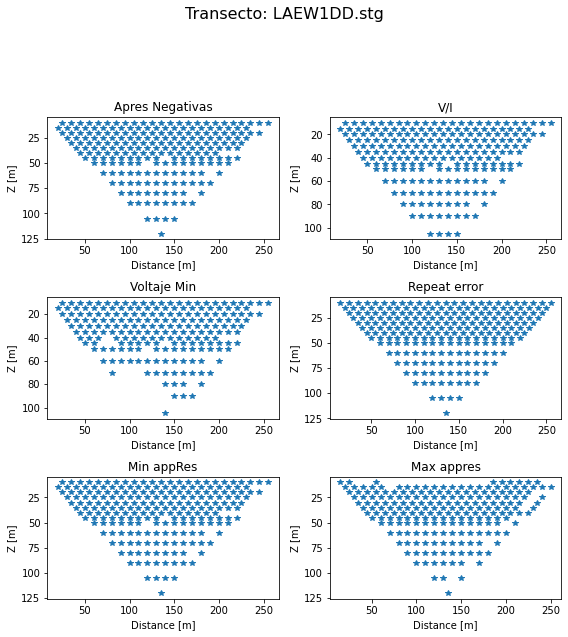

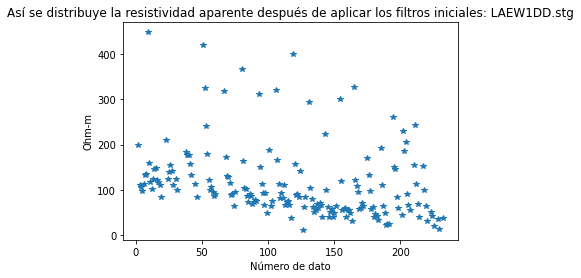

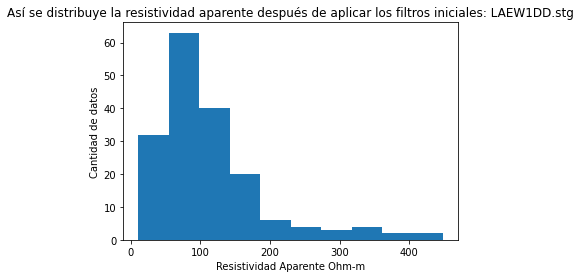

En resumen, el archivo crudo LAEW1DD.stg tenía 237 y termina con 176 
 Es decir, se pierden 61 datos.


In [7]:
LAEW1DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1DD.stg'
stg_initial_settings_filters(LAEW1DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([151], dtype='int64') en total: 1




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([151], dtype='int64') en total: 1


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([151], dtype='int64') en total: 1


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([1, 2, 11, 22, 29, 38, 47, 57, 67, 77, 88, 97, 107], dtype='int64') en total: 13


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([151], dtype='int64') en total: 1




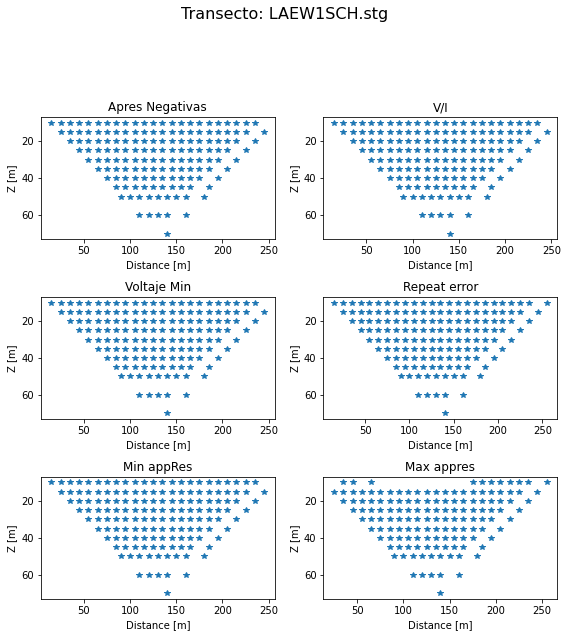

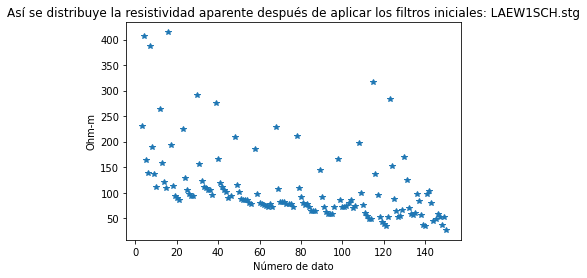

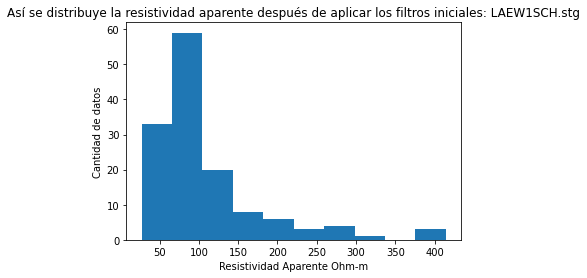

En resumen, el archivo crudo LAEW1SCH.stg tenía 151 y termina con 137 
 Es decir, se pierden 14 datos.


In [8]:
LAEW1SCH = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1SCH.stg'
stg_initial_settings_filters(LAEW1SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([109], dtype='int64') en total: 1




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([109], dtype='int64') en total: 1


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([109], dtype='int64') en total: 1


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([9, 17, 39, 52, 58, 63, 69, 74, 78, 83, 87, 90, 94], dtype='int64') en total: 13


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([109], dtype='int64') en total: 1




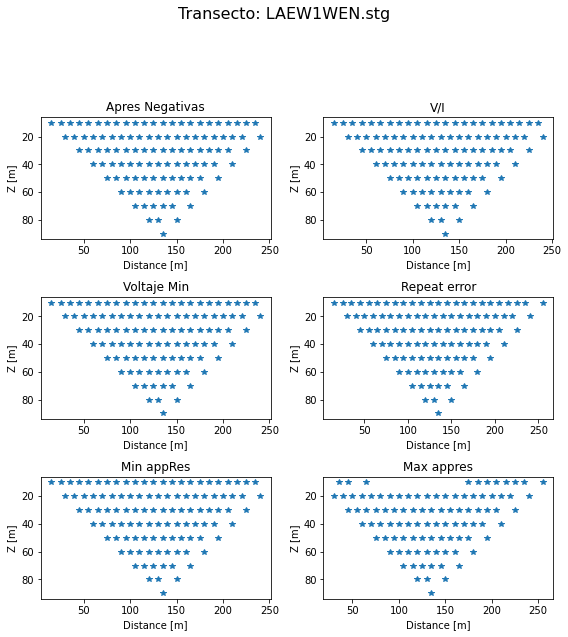

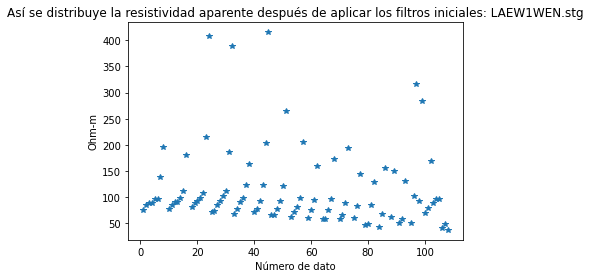

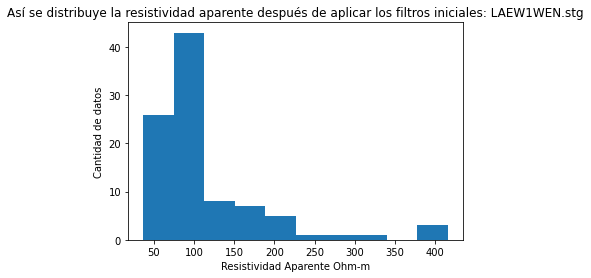

En resumen, el archivo crudo LAEW1WEN.stg tenía 109 y termina con 95 
 Es decir, se pierden 14 datos.


In [9]:
LAEW1WEN = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW1WEN.stg'
stg_initial_settings_filters(LAEW1WEN ,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 270.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([129, 152, 171, 173, 183, 200, 208, 214, 215, 221, 227, 229, 231,
            233, 235, 237],
           dtype='int64') en total: 16




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([129, 152, 171, 173, 183, 191, 199, 200, 208, 214, 215, 221, 227,
            229, 231, 233, 235, 237],
           dtype='int64') en total: 18


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([129, 152, 171, 173, 183, 191, 199, 200, 208, 214, 215, 221, 227,
            229, 231, 233, 235, 237],
           dtype='int64') en total: 18


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del Ma

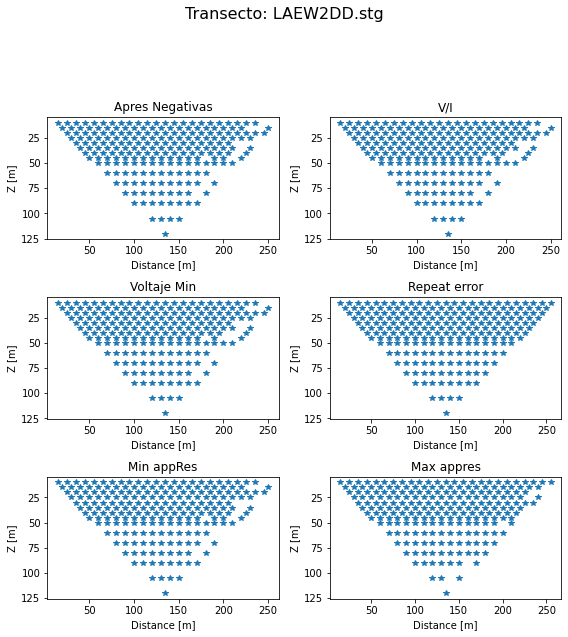

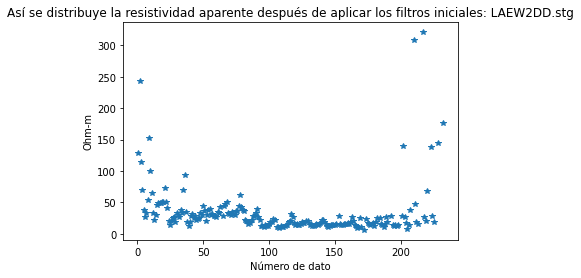

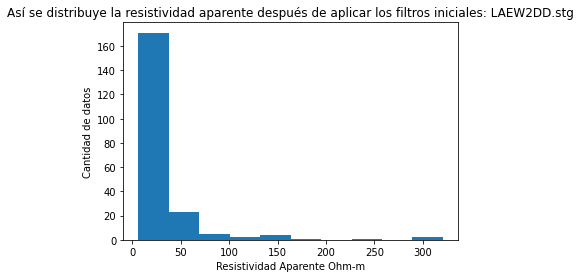

En resumen, el archivo crudo LAEW2DD.stg tenía 237 y termina con 209 
 Es decir, se pierden 28 datos.


In [10]:
LAEW2DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW2DD.stg'
stg_initial_settings_filters(LAEW2DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([], dtype='int64') en total: 0




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([151], dtype='int64') en total: 1


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([], dtype='int64') en total: 0




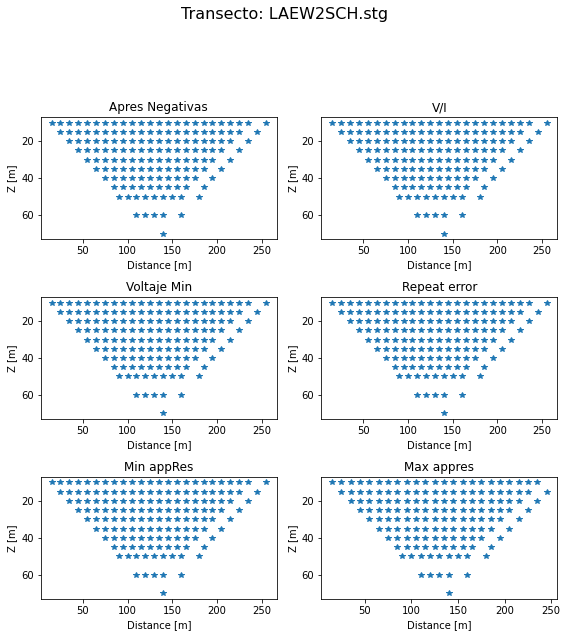

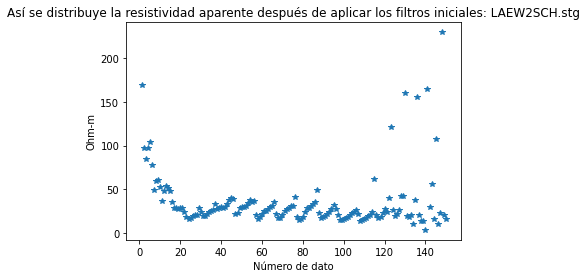

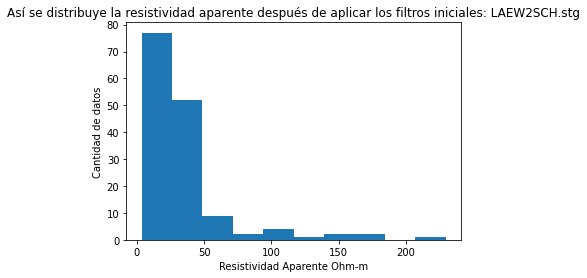

En resumen, el archivo crudo LAEW2SCH.stg tenía 151 y termina con 150 
 Es decir, se pierden 1 datos.


In [11]:
LAEW2SCH = r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LA/LAEW2SCH.stg'
stg_initial_settings_filters(LAEW2SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

# 🟧 Dipolo - Dipolo  Lineas naranjas



El valor máximo en x de los electrodos es 270.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([  5,   7,   8,  19,  34,  36,  46,  62,  70,  71,  72,  83,  87,
             89,  90,  96, 106, 112, 115, 119, 128, 133, 136, 137, 140, 145,
            149, 154, 160, 164, 166, 168, 169, 170, 172, 174, 176, 178, 187,
            188, 195, 197],
           dtype='int64') en total: 42




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([  5,   7,   8,  19,  21,  34,  36,  46,  62,  69,  70,  71,  72,
             73,  74,  75,  76,  77,  83,  87,  89,  90,  96, 106, 109, 110,
            112, 115, 119, 128, 132, 133, 136, 137, 138, 140, 145, 149, 154,
            160, 164, 166, 168, 169, 170, 172, 174, 176, 178, 187, 188, 195,
            197],
           dtype='int64') en total: 53


Los datos a eliminar p

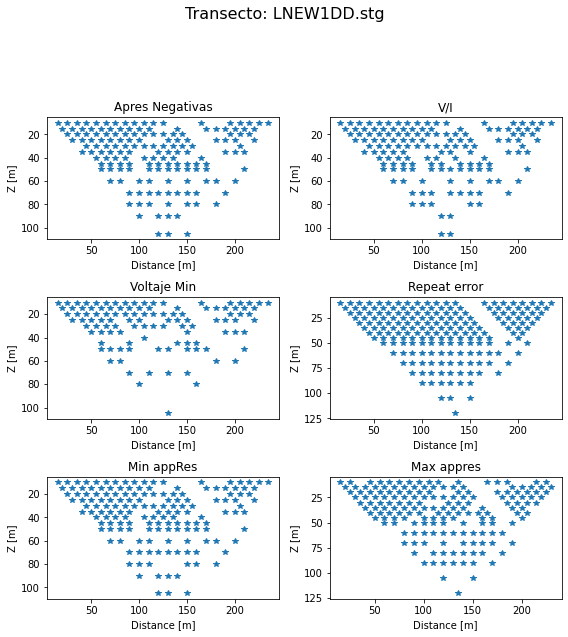

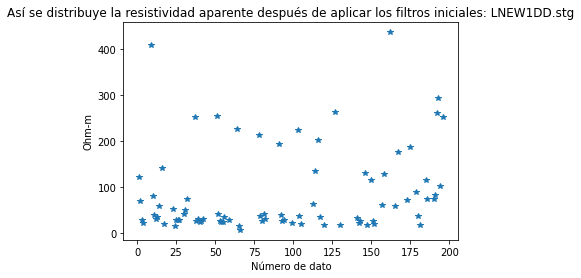

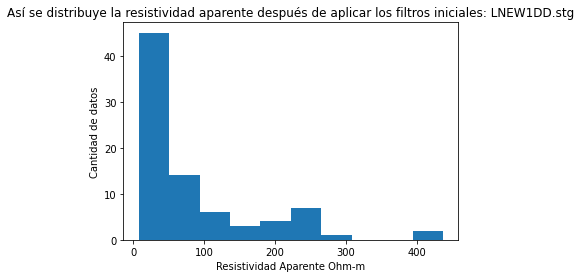

En resumen, el archivo crudo LNEW1DD.stg tenía 198 y termina con 82 
 Es decir, se pierden 116 datos.


In [12]:
LNEW1DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW1DD.stg'
stg_initial_settings_filters(LNEW1DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 260.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([73, 75, 76, 77, 84, 88, 89, 90, 91, 92, 115, 116, 117, 142, 149], dtype='int64') en total: 15




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([73, 75, 76, 77, 84, 88, 89, 90, 91, 92, 115, 116, 117, 142, 149], dtype='int64') en total: 15


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([73, 75, 76, 77, 84, 88, 89, 90, 91, 92, 98, 115, 116, 117, 142,
            149],
           dtype='int64') en total: 16


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([87, 117], dtype='int64') en total: 2


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([69, 70, 71, 74, 78, 79, 85, 86, 138, 150], dtype='int64') en total: 10


Lo

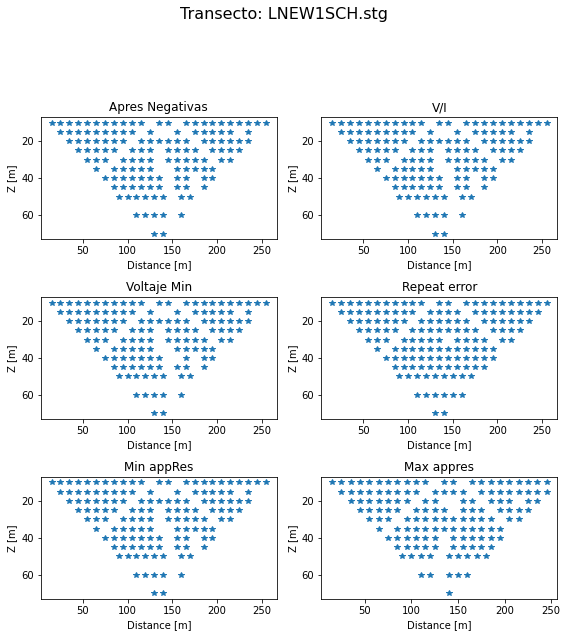

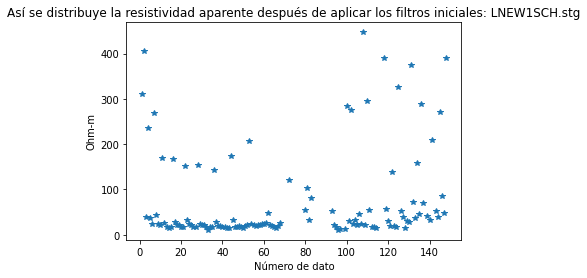

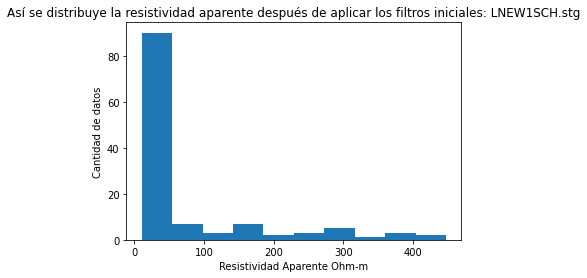

En resumen, el archivo crudo LNEW1SCH.stg tenía 150 y termina con 123 
 Es decir, se pierden 27 datos.


In [13]:
LNEW1SCH=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW1SCH.stg'
stg_initial_settings_filters(LNEW1SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 270.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([29, 32, 34, 36, 64, 86, 163, 183, 199, 201, 208, 222, 235], dtype='int64') en total: 13




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([29, 32, 33, 34, 35, 36, 50, 64, 86, 163, 183, 199, 201, 208, 222,
            235],
           dtype='int64') en total: 16


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([ 20,  21,  28,  29,  30,  31,  32,  33,  34,  35,  36,  47,  48,
             49,  50,  56,  57,  58,  61,  62,  63,  64,  77,  85,  86,  88,
             89,  90,  91, 103, 104, 163, 183, 191, 199, 201, 208, 222, 235],
           dtype='int64') en total: 39


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0

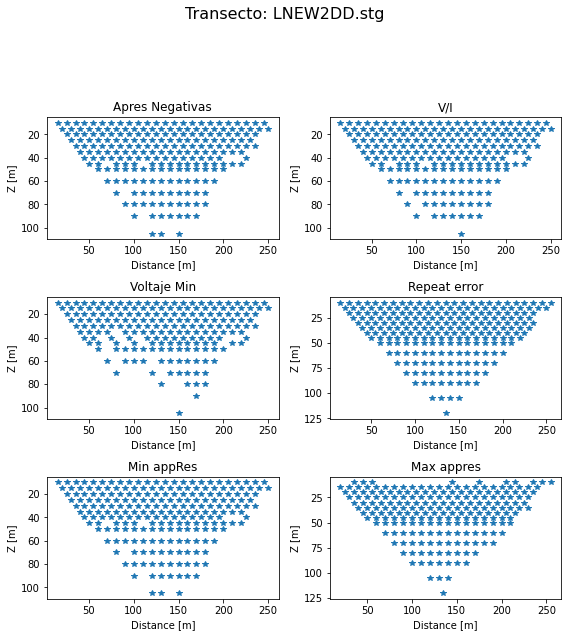

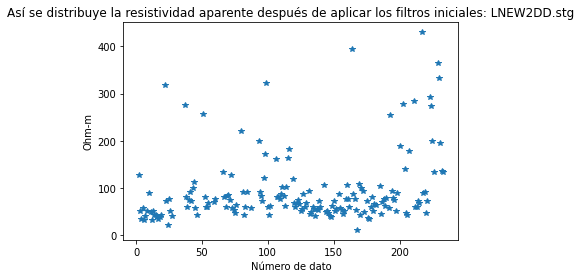

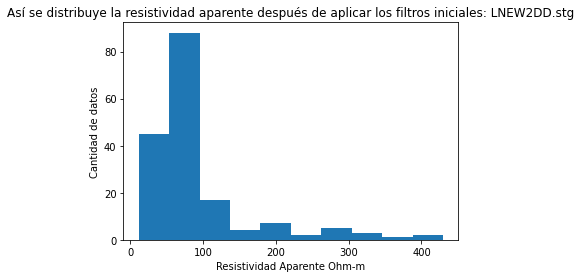

En resumen, el archivo crudo LNEW2DD.stg tenía 235 y termina con 174 
 Es decir, se pierden 61 datos.


In [14]:
LNEW2DD=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW2DD.stg'
stg_initial_settings_filters(LNEW2DD,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)

El valor máximo en x de los electrodos es 250.0


OJO, los informes aquí emplean el ID del archivo .stg, osea la primer columna del archivo stg 
 Para el Earth Imager el número de dato será un número menos porque empieza a contar desde cero


Los datos a eliminar porque las apres son negativas son: Int64Index([], dtype='int64') en total: 0




Los datos a eliminar porque son menores al mínimo V/I son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por debajo del voltaje mínimo son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxRepeatErr son: Int64Index([], dtype='int64') en total: 0


Los datos a eliminar porque están por arriba del MaxAppRes son: Int64Index([22, 29, 38, 47], dtype='int64') en total: 4


Los datos a eliminar porque están por debajo del MinAppRes son: Int64Index([], dtype='int64') en total: 0




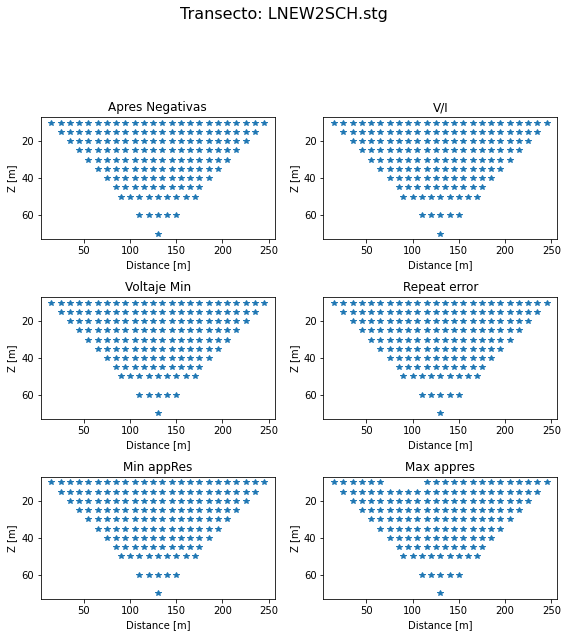

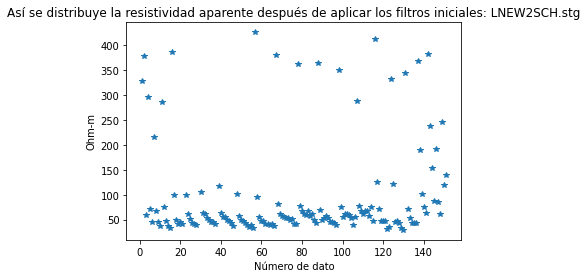

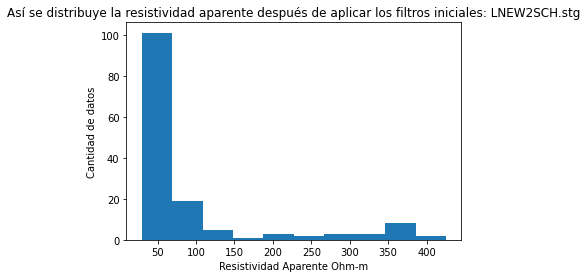

En resumen, el archivo crudo LNEW2SCH.stg tenía 151 y termina con 147 
 Es decir, se pierden 4 datos.


In [15]:
LNEW2SCH=r'/content/drive/MyDrive/Colab Notebooks/mariana_escuela_verano_2022_EarthImager_mariana/LN/LNEW2SCH.stg'
stg_initial_settings_filters(LNEW2SCH,MinVoverI,MinVoltage,MaxRepeatErr,MaxAppRes,MinAppRes)